<a href="https://colab.research.google.com/github/andysingal/CaliforniaHousing_Prices/blob/main/Cali_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@ Initialization:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## LIBRARIES


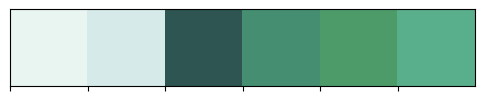

In [4]:

#@ Downloading the Libraries and Dependencies:
import sys, os, tarfile, urllib.request
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#@ Visualization Dependencies:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = "."
ID = "California Housing"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", ID)
if not os.path.isdir(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving Figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#@ Ignoring the Warnings:
import warnings
warnings.filterwarnings(action="ignore", message="^ internal")

#color pallet and theme
import matplotlib.colors

colors = ["#e9f5f0","#d5eae9","#2e5551",'#468e71','#4d9b68','#59ae8c']
colors2 = ["#2e5551",'#468e71','#4d9b68','#59ae8c', "#e9f5f0","#d5eae9"]
cmap = matplotlib.colors.ListedColormap(colors2)

sns.palplot(sns.color_palette(colors))


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#Download the Data

In [6]:
#@ Getting the Data:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()                                                           # Initializing the Function.

#@ Getting the Data:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

#@ Inspecting the Data:
housing = load_housing_data()
print(pd.Series({"Memory usage": "{:.2f} MB".format(housing.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(housing.shape)}).to_string())
housing.head(7)                            

Memory usage         1.57 MB
Dataset shape    (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


# Exploratory Data Analysis
The analysis report presents that the DataFrame has 20640 rows and each row represents one district. The report also presents that the DataFrame has 10 features where one is categorical and 9 are numerical. The info method is standard and useful to get the quick description of the Data, in particular the attributes type and the number of non null values.

In [8]:
# Shape of the data
print(pd.Series({"Shape of the training set": housing.shape}).to_string())

Shape of the training set    (20640, 10)


In [9]:
# Count of columns
df_cols_count = pd.DataFrame(index = ['Number of columns'], columns = ['Training set'])
df_cols_count['Training set'] = len(housing.columns)
df_cols_count

,Training set
Number of columns,10


In [10]:
# Column names for the training dataset
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [11]:
# Column datatypes for the training dataset
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [12]:
# Integer columns in the training dataset
housing.columns[housing.dtypes == 'int64']

Index([], dtype='object')

In [14]:
# Object columns in the training dataset
housing.columns[housing.dtypes == 'object']

Index(['ocean_proximity'], dtype='object')

In [15]:
# Count of duplicate rows
df_duplicate_rows = pd.DataFrame(index = ['Number of duplicate rows'], columns = ['Training set'])
df_duplicate_rows['Training set'] = housing.duplicated().sum()
df_duplicate_rows

,Training set
Number of duplicate rows,0


In [16]:
# Constant columns in the training set
cols_constant_train = housing.columns[housing.nunique() == 1].tolist()
if len(cols_constant_train) == 0:
    cols_constant_train = "None"
print(pd.Series({"Constant columns in the training set": cols_constant_train}).to_string())

Constant columns in the training set    None


In [17]:
# Count of columns with missing values
df_missing = pd.DataFrame(index = ['Number of columns with missing values'], columns = ['Training set'])
df_missing['Training set'] = len(housing.isna().sum()[housing.isna().sum() != 0])
df_missing

,Training set
Number of columns with missing values,1
